In [56]:
import tensorflow as tf

print(tf.__version__)
print(tf.keras.__version__)
from matplotlib import pyplot as plt
import os
import random
import matplotlib.pyplot as pltBVGGBHBNM
import os

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm
import numpy as np
from datetime import datetime

2.12.0
2.12.0


In [57]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [58]:
INPUT_SIZE = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 32
IMAGE_SIZE = (192, 192)



train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/PetImages/Train/",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=999,
    validation_split=0.20,
    subset="training",
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/PetImages/Test/",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=999,
    validation_split=0.20,
    subset="validation",
)
class_names = train_dataset.class_names

Found 6210 files belonging to 2 classes.
Using 4968 files for training.
Found 2004 files belonging to 2 classes.
Using 400 files for validation.


In [59]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [60]:
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [61]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [62]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.4)    
      ])

In [63]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

In [ ]:
try:
    image_batch, label_batch = next(iter(train_dataset))

except Exception as e:
    print(f"Error processing image: {e}")
    
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

(32, 6, 6, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

In [ ]:
import tensorflow as tf

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
initial_epochs =30

loss0, accuracy0 = model.evaluate(validation_dataset)

11/11 [==============================] - 7s 435ms/step - loss: 0.9984 - accuracy: 0.3304


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.00
initial accuracy: 0.33


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
162/208 [======================>.......] - ETA: 21s - loss: 0.7285 - accuracy: 0.5579

InvalidArgumentError: Graph execution error:

Input size should match (header_size + row_size * abs_height) but they differ by 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_43689]

In [ ]:
date_string = f'{datetime.now():%Y%m%d%H%M%S%z}'
model.save('Model/model'+ date_string+'.h5')

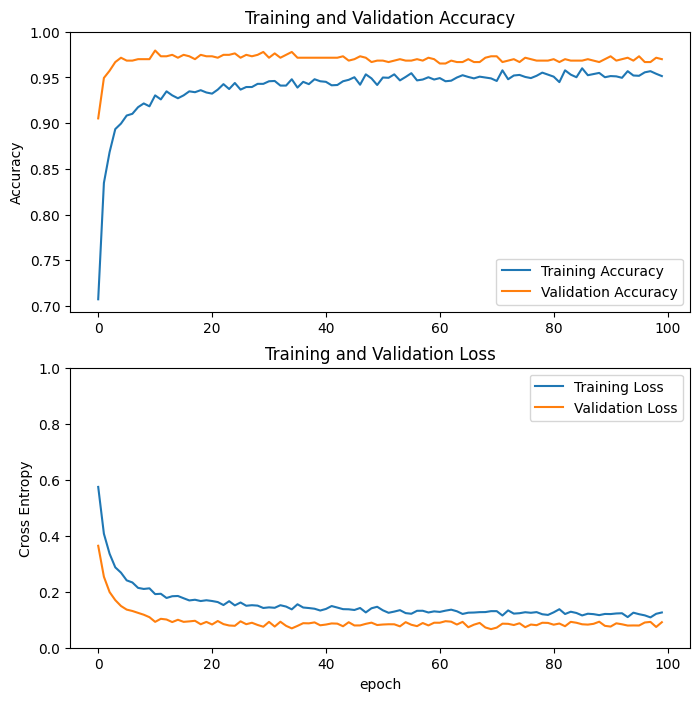

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#set the base model variable "trainable" to True
base_model.trainable=True
print(base_model.trainable)

True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = -10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 100/110
100/100 [==============================] - 64s 599ms/step - loss: 0.1206 - accuracy: 0.9531 - val_loss: 0.0938 - val_accuracy: 0.9668
Epoch 101/110
100/100 [==============================] - 62s 615ms/step - loss: 0.1234 - accuracy: 0.9509 - val_loss: 0.0894 - val_accuracy: 0.9700
Epoch 102/110
100/100 [==============================] - 57s 574ms/step - loss: 0.1163 - accuracy: 0.9553 - val_loss: 0.0772 - val_accuracy: 0.9731
Epoch 103/110
 50/100 [==============>...............] - ETA: 25s - loss: 0.1079 - accuracy: 0.9638

In [ ]:
date_string = f'{datetime.now():%Y%m%d%H%M%S%z}'
model.save('finetune/model'+ date_string+'.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have a trained model called 'model' and a test dataset called 'test_dataset'

# Make predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print the metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))

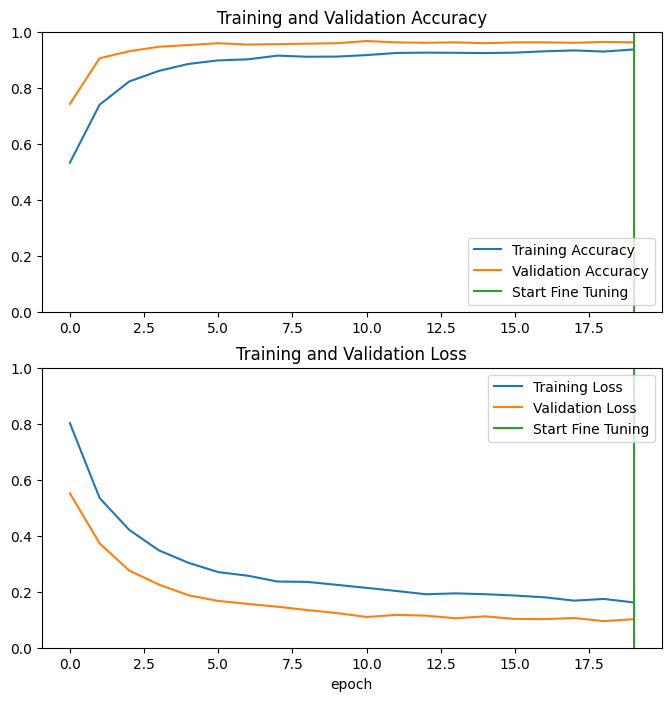

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 2s 429ms/step - loss: 0.0942 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1]
Labels:
 [0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1]


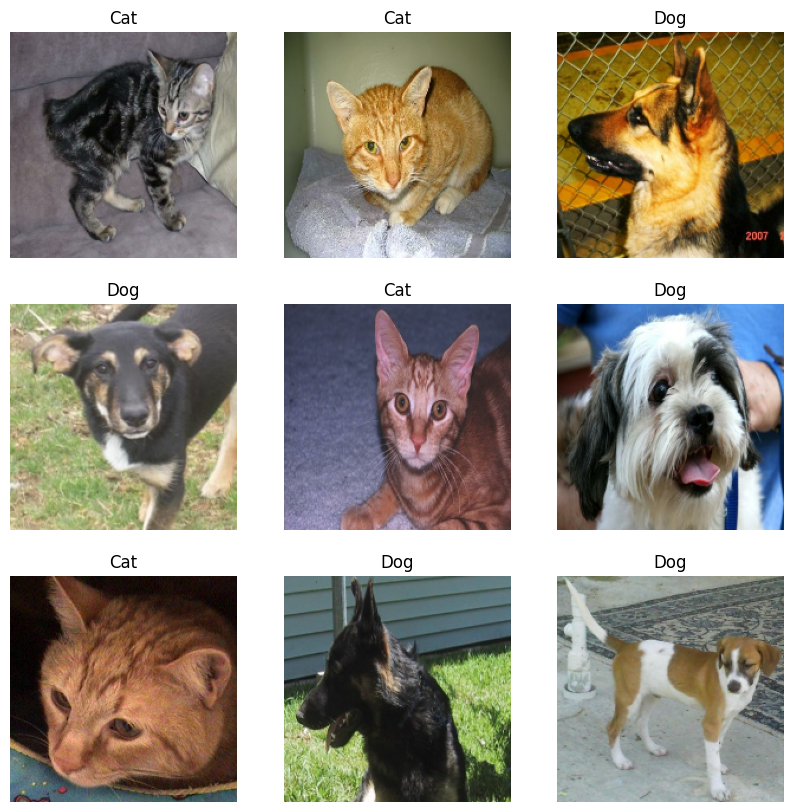

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")